In [1]:
import torch
from Models import Params,SepVAE,CrossAttention, SepVAEEncoder
import torch.nn as nn
import torchinfo
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup
from pathlib import Path
from Models.utils import OneHotDist
from einops import rearrange

In [2]:
# test cross attention

crs = CrossAttention(17,35)
input1 = torch.randn(size = (3,17,16,16))
input2 = torch.randn(size = (3,35,17,17))

with torch.no_grad():
    a = crs(input1,input2)

In [2]:
dummy = torch.randn(size= (3,3,128,128))

params = Params(discrete=True, use_conv=True)

params.conv_neckdim = 32
params.ber = True

model = SepVAE(params)

In [4]:
print(torchinfo.summary(model))

Layer (type:depth-idx)                                       Param #
SepVAE                                                       --
├─SepVAEEncoder: 1-1                                         --
│    └─Conv2d: 2-1                                           448
│    └─ModuleList: 2-2                                       --
│    │    └─ModuleList: 3-1                                  13,984
│    │    └─ModuleList: 3-2                                  15,024
│    │    └─ModuleList: 3-3                                  43,360
│    │    └─ModuleList: 3-4                                  139,968
│    └─ModuleList: 2-3                                       --
│    │    └─ModuleList: 3-5                                  50,848
│    │    └─ModuleList: 3-6                                  35,504
│    │    └─ModuleList: 3-7                                  76,128
│    │    └─ModuleList: 3-8                                  139,968
│    └─CrossAttention: 2-4                                   --


In [3]:
with torch.no_grad():
    a = model(dummy)

In [3]:
class Dummyset(Dataset):
    def __init__(self, input_size, length):
        self.length = length
        self.data = torch.randn(size = (length,3,input_size,input_size))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.data[idx]

In [5]:
with torch.no_grad():
    b = model.elbo(a[0],a[1],a[2],a[3],a[-1],dummy)

In [4]:
print(torchinfo.summary(model))

Layer (type:depth-idx)                                  Param #
SepVAE                                                  --
├─Conv2d: 1-1                                           448
├─ModuleList: 1-2                                       --
│    └─ModuleList: 2-1                                  --
│    │    └─ResnetBlock: 3-1                            4,704
│    │    └─Residual: 3-2                               8,240
│    │    └─Conv2d: 3-3                                 1,040
│    └─ModuleList: 2-2                                  --
│    │    └─ResnetBlock: 3-4                            4,704
│    │    └─Residual: 3-5                               8,240
│    │    └─Conv2d: 3-6                                 2,080
│    └─ModuleList: 2-3                                  --
│    │    └─ResnetBlock: 3-7                            18,624
│    │    └─Residual: 3-8                               16,480
│    │    └─Conv2d: 3-9                                 18,496
├─ModuleList: 1-3   

In [4]:
from Models.utils import Trainer

In [5]:
trainset = Dummyset(128,200)
testset = Dummyset(128,50)
train_loader = DataLoader(trainset,batch_size = 16,shuffle=True)
test_loader = DataLoader(testset, batch_size=  16, shuffle = False)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=30,num_training_steps=1000)

In [6]:
tr = Trainer(model,optimizer=optimizer,scheduler=scheduler,train_loader=train_loader,test_loader=test_loader,training_step=100,report_step=10,save_path=Path("./"),device = torch.device('cuda:0'),num_sample=2)

step:0, loss:281988.937500, finekl:75.470055,coarsekl:110.250854,L:281803.218750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


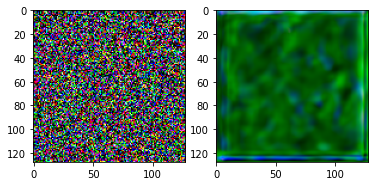

step:10, eval_loss:280034.178823, finekl:74.644188,coarsekl:108.019011,L:279851.515625
step:10, loss:281786.903125, finekl:75.480163,coarsekl:109.485251,L:281601.940625


KeyboardInterrupt: 

In [7]:
tr.train()

In [11]:
data = torch.randn(3,32,16,16)
data = rearrange(data, 'b c h w -> b h w c')
dis1 = OneHotDist(logits = data)
print(dis1.sample().shape)


torch.Size([3, 16, 16, 32])


In [ ]:
data = rearrange(data, 'b c h w -> b h w c')